In [6]:
# Reading the images:
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm

def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in tqdm(range(0,43)):
        #print(c)
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

images, labels = readTrafficSigns("GermanDataset\\GTSRB_Final_Training_Images\\GTSRB\\Final_Training\\Images")
print(images[0])
print(labels[0])

100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:13<00:00,  3.11it/s]


[[[ 75  78  80]
  [ 74  76  78]
  [ 86  87  84]
  ...
  [ 68  75  75]
  [ 65  69  68]
  [ 66  67  66]]

 [[ 83  84  86]
  [ 80  80  82]
  [ 90  89  84]
  ...
  [ 73  77  78]
  [ 76  78  75]
  [ 80  80  78]]

 [[ 78  78  80]
  [ 86  85  86]
  [ 93  90  91]
  ...
  [ 72  74  72]
  [ 73  74  69]
  [ 78  78  74]]

 ...

 [[133 134 139]
  [122 127 132]
  [112 121 124]
  ...
  [ 94  94  89]
  [ 97  98  91]
  [ 99 103  99]]

 [[ 91  95  99]
  [ 91  98 103]
  [ 74  85  89]
  ...
  [103 101  95]
  [110 113 104]
  [ 96 104  98]]

 [[ 85  84  87]
  [ 95 101 107]
  [ 61  74  79]
  ...
  [102 102  95]
  [ 99 102  90]
  [ 90  97  89]]]
0


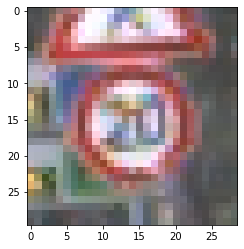

In [7]:
plt.imshow(images[0])

In [10]:
print(type(images[0]))
print(len(images[0]))

<class 'numpy.ndarray'>
30


In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import csv
from PIL import Image

In [28]:
REBUILD_DATA = True # Set it to true once!!

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

#img = mpimg.imread('image.png')     
#gray = rgb2gray(img)    
#plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
#plt.show()


if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

class StreetSigns():
    imageSize = 50
    #labels = {cats : 0, dogs : 1} # TODO Later
    labels = [] # maybe not needed TODO
    trainingData = []
    def makeTrainingData(self, rootpath):
        for c in tqdm(range(0,43)):
        #print(c)
            prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
            gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
            gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
            next(gtReader) # skip header
            # loop over all images in current annotations file
            for row in gtReader:
                img = plt.imread(prefix + row[0])
                img = cv2.resize(img, (self.imageSize, self.imageSize))
                img = np.array(img)
                #plt.imshow(img)
                img = rgb2gray(img) 
                label = int(row[7])
                self.labels.append(label) # the 8th column is the label
                self.trainingData.append([np.array(img), np.eye(43)[label]])

            gtFile.close()
                
                
        np.random.shuffle(self.trainingData)
        np.save("StreetSignsData.npy", self.trainingData)
        
        
if REBUILD_DATA:
    streetSigns = StreetSigns()
    streetSigns.makeTrainingData("GermanDataset\\GTSRB_Final_Training_Images\\GTSRB\\Final_Training\\Images")

  0%|                                                                                           | 0/43 [00:00<?, ?it/s]

Running on the GPU


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [01:42<00:00,  2.40s/it]


In [29]:
trainingData = np.load("StreetSignsData.npy", allow_pickle = True)
print(len(trainingData))
print(trainingData[1000])

39209
[array([[ 54.0377,  48.2232,  42.5227, ...,  63.1797,  77.3137,  89.22  ],
       [ 54.8527,  50.337 ,  43.6366, ...,  75.7502,  76.6791,  83.4827],
       [ 54.5538,  51.6358,  42.9356, ...,  70.9634,  73.017 ,  85.1729],
       ...,
       [ 55.7772,  55.9621,  56.7771, ..., 105.4283, 147.8586, 157.4555],
       [ 57.2178,  63.6471,  60.2175, ..., 104.8243, 148.3963, 157.0642],
       [ 73.113 ,  78.0694,  78.8135, ..., 105.3512, 147.7061, 156.3309]])
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])]


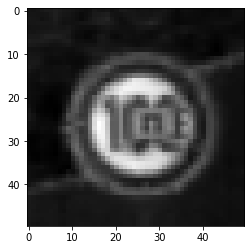

In [6]:
# Let's show a picture
plt.imshow(trainingData[1][0], cmap="gray")
plt.show()

In [8]:
# Our Neural Netowrk Class
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Kernel/Window is 5
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x) # part of the forward
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 43)
        
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))        
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        
        #print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
            
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear) # To linear ?????
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [9]:
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.001)
lossFunction = nn.MSELoss()
x = torch.Tensor([i[0] for i in trainingData]).view(-1, 50, 50)
x = x/255.0
y = torch.Tensor([i[1] for i in trainingData])
valPct = 0.1
valSize = int(len(x)*valPct)
print(valSize)

trainX = x[:-valSize]
trainY = y[:-valSize]

testX = x[-valSize:]
testY = y[-valSize:]

print(len(trainX))
print(len(testX))

3920
35289
3920


In [13]:
batchSize = 100
epochs = 9
def train(net):
    optimizer = optim.Adam(net.parameters(), lr = 0.001)
    lossFunction = nn.MSELoss()
    for epoch in range(epochs):
        for i in tqdm(range(0, len(trainX), batchSize)):
            #print(i, i + batchSize)
            batchX = trainX[i:i+batchSize].view(-1,1,50,50)
            batchY = trainY[i:i+batchSize]
            
            batchX, batchY = batchX.to(device), batchY.to(device)
            
            net.zero_grad() # or optimizer.zero_grad because 1 optimizer exists
            outputs = net(batchX)
            loss = lossFunction(outputs, batchY)
            loss.backward()
            optimizer.step()
            
        print(f"Epoch: {epoch}, Loss: {loss}")
        

In [14]:
def test(net):
    correct = 0
    total = 0

    with torch.no_grad():
        for i in tqdm(range(len(testX))):
            realClass = torch.argmax(testY[i]).to(device) 
            netOut = net(testX[i].view(-1,1,50,50).to(device))[0]
            predictedClass = torch.argmax(netOut)
            if predictedClass == realClass:
                correct += 1
            total += 1
    print("Accurancy:", round(correct/total,3))

In [15]:
def forwardPass(x, y, train = False):
    if train:
        net.zero_grad()
    outputs = net(x)
    #print("y is :")
   # print(y[0])
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs,y)]
    acc = matches.count(True)/len(matches)
    # there's still code to do here
    loss = lossFunction(outputs, y)
    
    if train:
        loss.backward()
        optimizer.step()
        
    return acc, loss

In [16]:
import numpy as np

def test(size=32):
    randomStart = np.random.randint(len(testX)-size)
    x, y = testX[randomStart:randomStart + size], testY[randomStart:randomStart+size]
    with torch.no_grad():
        valAcc, valLoss = forwardPass(x.view(-1,1,50,50).to(device), y.to(device))
    return valAcc, valLoss

valAcc, valLoss = test(size=32)
#print(valAcc, valLoss)

In [20]:
import time
from tqdm import tqdm

modelName = f"model-{int(time.time())}"

net = Net().to(device)

optimizer = optim.Adam(net.parameters(), lr = 0.001)
lossFunction = nn.MSELoss()

#print(modelName)

def train():
    batchSize = 50
    epochs = 3
    with open("model.log", "a") as f:
        for epoch in range(epochs):
            for i in tqdm(range(0, len(trainX), batchSize)):
                batchX = trainX[i:i+batchSize].view(-1,1,50,50).to(device)
                batchY = trainY[i:i+batchSize].to(device)
                
                acc, loss = forwardPass(batchX, batchY, train = True)
                if i % 25 == 0:
                    valAcc, valLoss = test(size=50)
                    f.write(f"{modelName},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss),4)},{round(float(valAcc),2)},{round(float(valLoss),4)}\n")
                    
train()
                
                

100%|████████████████████████████████████████████████████████████████████████████████| 706/706 [01:34<00:00,  7.43it/s]


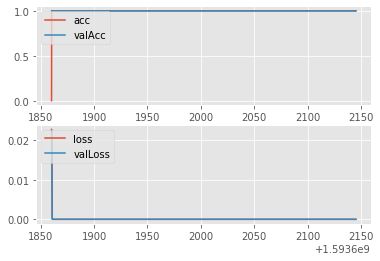

In [23]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

# we already have the variable modelName

def createAccLossGraph(modelName):
    contents = open("model.log", "r").read().split('\n')
    
    times = []
    accuarncies = []
    losses = []
    
    valAccs = []
    valLosses = []
    
    for c in contents:
        if modelName in c:
            name, timestamp, acc, loss, valAcc, ValLoss = c.split(",")
            
            times.append(float(timestamp))
            accuarncies.append(float(acc))            
            losses.append(float(loss))
            
            valAccs.append(float(valAcc))            
            valLosses.append(float(ValLoss))
            
    fig = plt.figure() #because we need more than one plot, if we need we would use plt.plot
    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex = ax1)
    
    ax1.plot(times, accuarncies, label="acc")
    ax1.plot(times, valAccs, label="valAcc")
    ax1.legend(loc=2)
    
    ax2.plot(times, losses, label="loss")
    ax2.plot(times, valLosses, label="valLoss")
    ax2.legend(loc=2)
    
    #debug

    plt.show()

    
createAccLossGraph(modelName)
    